## Data Analysis

在这个notebook中，我们将介绍数据分析模块的简单使用方法，并通过一个具体案例来介绍如何通过数据分析模块帮助模型优化

## 1、导入函数库

In [1]:
import paddle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123456)
paddle.seed(123456)

from paddlets import TSDataset
from paddlets.utils.backtest import backtest
from paddlets.analysis import Seasonality, Acf, Correlation
from paddlets.datasets.repository import get_dataset
from paddlets.transform import StandardScaler
from paddlets.pipeline.pipeline import Pipeline
from paddlets.models.forecasting import NBEATSModel

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

## 2、导入数据

调用get_dataset算子拉取已经集成的标准化ECL数据集

`get_dataset` 拉取数据集并返回TSDataset格式: 

- `name`: 拉取标准数据集名称，可选：{'UNI_WTH', 'ETTh1', 'ETTm1', 'ECL', 'WTH'}

In [2]:
data = get_dataset('ECL')

In [3]:
#减少列数提高后续计算效率
ts_cols = data.columns
keep_cols = ['MT_000', 'MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005',]
remove_cols = []
for col, type in ts_cols.items():
    if (type is 'target'):
        continue
    if (col not in keep_cols):
        remove_cols.append(col)

data.drop(remove_cols)

## 3、样本划分

In [4]:
data, _ = data.split('2014-06-30')
train_data, test_data = data.split('2014-06-15')
train_data, val_data = train_data.split('2014-06-01')

## 4、数据分析

数据分析模块主要包括周期性分析、特征相关性分析两部分，其中：

1、周期性分析可以为建模提供参数建议，如对于有明显周期性的数据，模型的输入参数in_chunk_len建议大于等于一个周期

2、特征相关性分析可以帮助用户筛选入模的特征，如对于与目标变量相关性极低的特征可以选择删除，避免影响模型效果

### 4.1 周期性分析

基于用户提供的周期性长度或者自动计算出来的周期性长度描绘周期性曲线

`Seasonality`旨在帮助用户自动化的分析和提取指定数据的周期性：

- `period`: 周期性长度，当输入数值时使用该数值计算周期性曲线，当为None（默认值）时采用自相关性策略自动计算周期长度

- `nlags`: 当period=None时，指定自相关性策略的阶数长度参数，default=300

- `alpha`: 当period=None时，判断自动计算的周期性长度的置信区间，dfault=0.05

- `mode`: 计算周期性曲线数值的模式策略，可选{"additive", "multiplicative"}

- `order`: 当period=None时，自动计算周期性长度的数值点左右区间各order个的自相关性数值小于该周期性长度时刻的自相关性数值

period:  {'MT_320': 24, 'MT_000': 24, 'MT_001': 12, 'MT_002': 13}


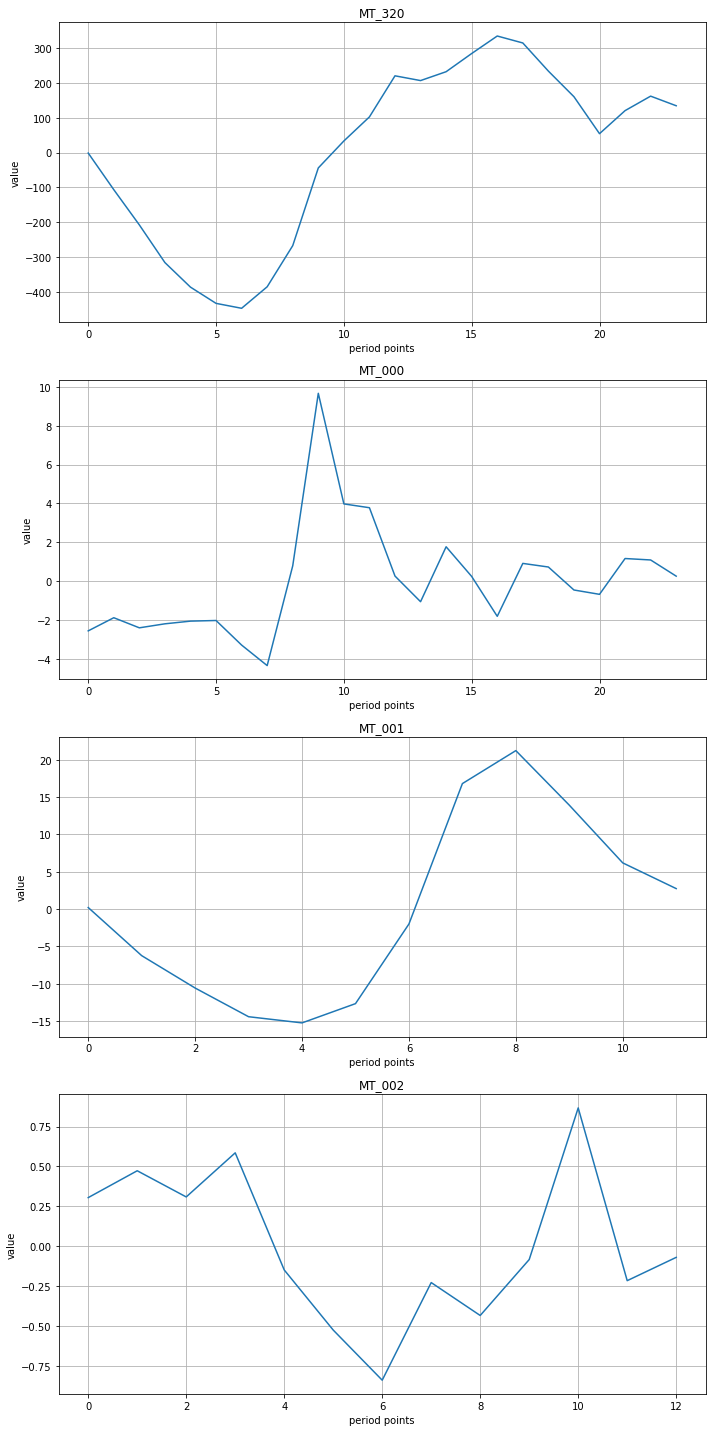

In [5]:
#周期性分析
sea = Seasonality(order=4) #order选取一定值，防止寻找局部最大值时受到干扰
se = sea(train_data, columns=['MT_320', 'MT_000', 'MT_001', 'MT_002'])
plot = sea.plot()
print('period: ', se[0])

### 4.2 特征相关性分析

基于所选特征列（默认所有）计算列之间的相关性

`Correlation`旨在帮助用户计算数据列之间的相关系数：

- `method`: 计算相关系数的方法，可选：{'pearson', 'kendall', 'spearman'}，也支持自定义指标函数

- `lag`: 延迟时间长度，当lag > 0时，针对lag_cols列进行延迟，便于用户计算目标列(target cols)与其他列(如observed_cols)之间的延迟相关性

- `lag_cols`: 需要延迟的列，当lag > 0时，针对lag_cols指定的列进行延迟

由于ECL数据集中没有known_cov变量，仅有observed_cov变量，此处调用lag参数计算target cols与observed_cols列之间延迟互相关特性

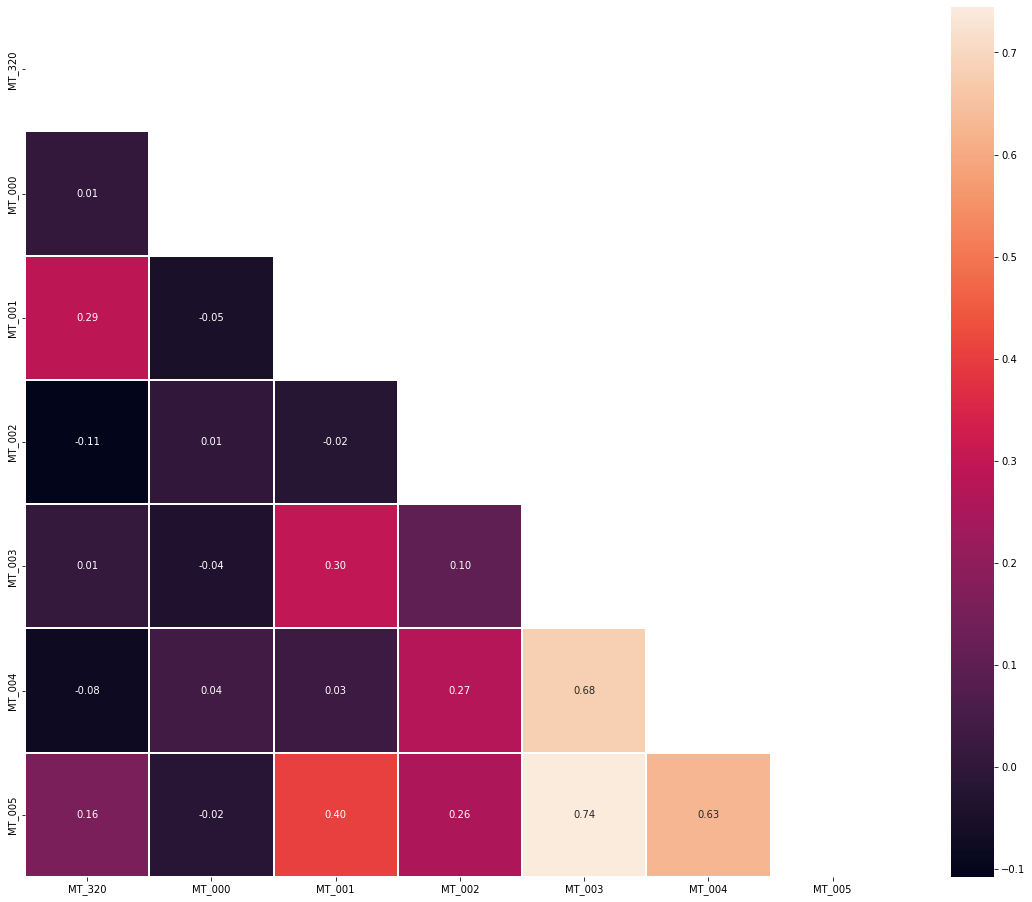

correlation:            MT_320    MT_000    MT_001    MT_002    MT_003    MT_004    MT_005
MT_320  1.000000  0.006587  0.288758 -0.107413  0.011876 -0.079538  0.158380
MT_000  0.006587  1.000000 -0.050612  0.005319 -0.037523  0.041871 -0.016419
MT_001  0.288758 -0.050612  1.000000 -0.017856  0.295764  0.026558  0.401940
MT_002 -0.107413  0.005319 -0.017856  1.000000  0.104992  0.273762  0.255482
MT_003  0.011876 -0.037523  0.295764  0.104992  1.000000  0.680421  0.744417
MT_004 -0.079538  0.041871  0.026558  0.273762  0.680421  1.000000  0.627420
MT_005  0.158380 -0.016419  0.401940  0.255482  0.744417  0.627420  1.000000


In [6]:
#特征相关性分析
cor = Correlation(method='spearman', lag=24, lag_cols=['MT_000', 'MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005']) #method提供三种计算方法{'pearson', 'kendall', 'spearman'}，同时支持自定义函数（比如计算延迟互相关）
c = cor(train_data)
plot = cor.plot()
print('correlation: ', c)

### 分析建议：

1、数据分析中显示训练集合的目标数据具备周期性，且周期性最小为24，故选择模型构建特征集合的时候，历史特征长度in_chunk_len最小应该为24，可以设置为24的倍数

2、与目标特征相关程度最低的可以考虑删除，避免影响模型效果

## 5、参数指定

In [7]:
#目标列历史长度生成特征
in_chunk_len = 24
#预测未来长度
out_chunk_len = 24
#训练区间与预测区间相隔长度
skip_chunk_len = 0
#sampling_stride
sampling_stride = 24
#模型额外参数指定
max_epochs = 100
patience = 5

## 6、构建pipeline

这里调用Nbeats模型开展分析优化，调用Pipeline模块建立整体流程，关于Nbeats和Pipeline的使用说明可以参照相应的文档部分

In [8]:
pipeline_list = [(StandardScaler, {}), 
                 (NBEATSModel, {'in_chunk_len': in_chunk_len, 
                                'out_chunk_len': out_chunk_len, 
                                'skip_chunk_len': skip_chunk_len, 
                                'max_epochs': max_epochs, 
                                'patience': patience})
                ]
pipe = Pipeline(pipeline_list)

## 7、pipeline训练

In [9]:
pipe.fit(train_data, val_data)

[2022-11-01 10:08:57,030] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 3.099050| val_0_mae: 1.068408| 0:00:02s
[2022-11-01 10:08:59,479] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 1.007178| val_0_mae: 0.912291| 0:00:04s
[2022-11-01 10:09:01,957] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.731689| val_0_mae: 0.824733| 0:00:07s
[2022-11-01 10:09:04,379] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.591643| val_0_mae: 0.763928| 0:00:09s
[2022-11-01 10:09:06,798] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.506198| val_0_mae: 0.718455| 0:00:12s
[2022-11-01 10:09:09,165] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.447732| val_0_mae: 0.686879| 0:00:14s
[2022-11-01 10:09:11,554] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.405896| val_0_mae: 0.665283| 0:00:16s
[2022-11-01 10:09:13,891] [paddlets.models.common.callb

## 8、backtest回测

PS：此处按照通用的场景需求，采用backtest的方式计算多天时间预测结果，所谓backtest可以参照paddlets.utils.backtest文档解释说明

举例说明：以当前ECL数据集为例，用户需要预测每天24个点（每天1H一个点）的预测数值，用户从2014-06-20号开始预测start=pd.Timestamp('2014-06-20 00:00:00')，每次预测之间的间隔为stride=24，预测长度predict_window=24

In [10]:
res = backtest(
    test_data, #测试数据集
    pipe, 
    start=pd.Timestamp('2014-06-20 00:00:00'), #开始预测时间
    predict_window=24, #预测长度
    stride=sampling_stride, 
    return_predicts=True,
)
score, predict_result = res

Backtest Progress: 100%|██████████| 11/11 [00:00<00:00, 13.59it/s]


## 9、预测分析

PS：图中蓝色为真实曲线，其他颜色为预测曲线

### 9.1 预测结果对比

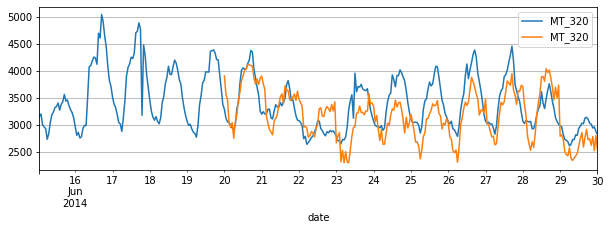

mse {'MT_320': 139654.5288533103}


In [11]:
#预测效果展示
plt.figure()
test_data.plot()
predict_result.plot()
plt.show()
print('mse', score)

对比预测曲线与真实曲线，预测曲线缺少趋势性上升，对于周期性的预测好坏需要进一步分析

### 9.2 残差曲线

<AxesSubplot:>

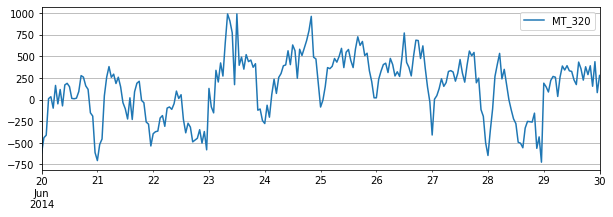

In [12]:
#残差曲线
p = predict_result.to_dataframe()
r = test_data.to_dataframe()
r = r[['MT_320']]
ts = TSDataset.load_from_dataframe((r - p).dropna(), target_cols="MT_320")
ts.plot()

可以看出来，预测误差中仍然存在明显的周期性数据，证明模型有进一步优化的空间，同时对比预测结果与真实结果，预测结果在趋势性上学习不明显

### 9.3 自相关性分析

时序自相关性计算策略，自相关性可以判断当前时刻和历史时刻是否具有相关性，帮助判断数据列是否存在显著的周期特性

`Acf`旨在帮助用户计算时序数据的自相关系数：

- `nlags`: 当period=None时，指定自相关性策略的阶数长度参数，default=300

- `alpha`: 当period=None时，判断自动计算的周期性长度的置信区间，dfault=0.05

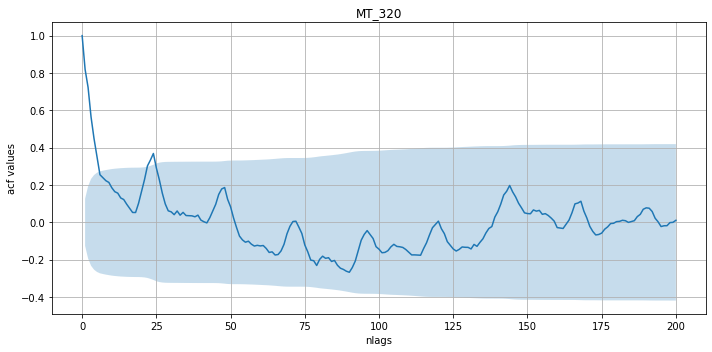

In [13]:
ts = TSDataset.load_from_dataframe((r - p).dropna(), target_cols="MT_320")
acf = Acf(nlags=200)
ac = acf(ts)
plot = acf.plot()

从自相关性分析来看，仍然部分斜率变化顶点（蓝色区域之外），表明预测误差具有显著的自相关性，也就是预测残差中仍有周期性数据没有被模型学习到，模型缺少一定的拟合程度，可以进一步开展优化策略

### 9.4 周期性分析

这里针对模型预测误差的周期性长度进行进一步提取，观测误差数据的周期性情况

period:  {'MT_320': 24}


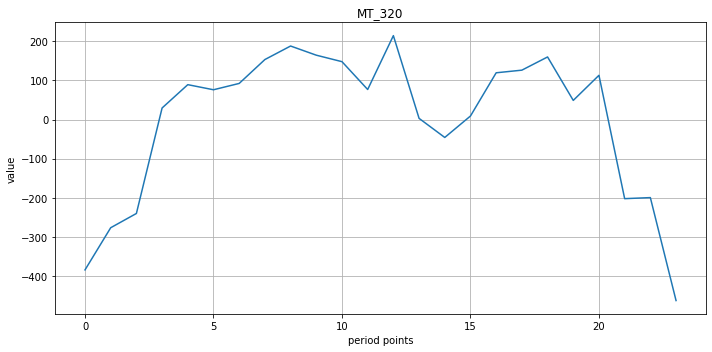

In [14]:
#周期性分析
ts = TSDataset.load_from_dataframe((r - p).dropna(), target_cols="MT_320")
sea = Seasonality(nlags=200, order=4)
se = sea(ts)
plot = sea.plot()
print('period: ', se[0])

通过周期性计算方法计算出来模型的预测误差中数据周期性为period = 24，模型效果仍然有进一步优化提示的空间

## 10、基于分析二次优化

上图的分析结果中显示出模型仍然有进一步学习的空间，一般模型网络学习性能欠缺包括两方面原因：

1、输入特征数据不足

2、模型网络复杂度较低

这里我们通过增加输入的特征数据和模型网络隐藏层节点数提升模型的学习能力

### 10.1 模型训练

In [15]:
np.random.seed(123456)
paddle.seed(123456)
#模型额外参数指定
layer_widths = 256 #default layer_widths=128
in_chunk_len = 24 * 2 #default in_chunk_len=24

pipeline_list = [(StandardScaler, {}), 
                 (NBEATSModel, {'in_chunk_len': in_chunk_len, 
                                'out_chunk_len': out_chunk_len, 
                                'skip_chunk_len': skip_chunk_len, 
                                'max_epochs': max_epochs, 
                                'patience': patience,
                                'layer_widths': layer_widths,})
                ]
pipe = Pipeline(pipeline_list)
#训练
pipe.fit(train_data, val_data)

[2022-11-01 10:10:34,320] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 2.733198| val_0_mae: 0.995070| 0:00:04s
[2022-11-01 10:10:39,188] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.787582| val_0_mae: 0.830915| 0:00:09s
[2022-11-01 10:10:43,854] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.552534| val_0_mae: 0.748365| 0:00:14s
[2022-11-01 10:10:48,441] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.441203| val_0_mae: 0.699927| 0:00:18s
[2022-11-01 10:10:53,042] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.376512| val_0_mae: 0.666884| 0:00:23s
[2022-11-01 10:10:57,832] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.333216| val_0_mae: 0.642005| 0:00:28s
[2022-11-01 10:11:02,719] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.302262| val_0_mae: 0.623225| 0:00:33s
[2022-11-01 10:11:07,690] [paddlets.models.common.callb

In [16]:
#回测backtest
res = backtest(
    test_data, #测试数据集
    pipe, 
    start=pd.Timestamp('2014-06-20 00:00:00'), #开始预测时间
    predict_window=24, #预测长度
    stride=24, 
    return_predicts=True,
)
score, predict_result = res

Backtest Progress: 100%|██████████| 11/11 [00:00<00:00, 13.42it/s]


### 10.2 预测分析

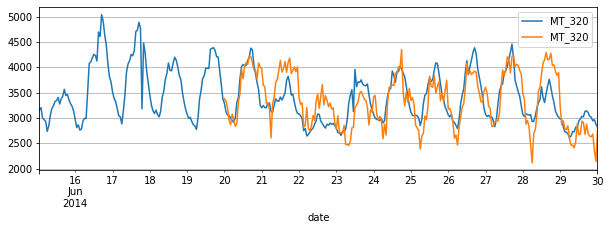

mse:  {'MT_320': 127563.02455913975}


In [17]:
#预测效果展示
plt.figure()
test_data.plot()
predict_result.plot()
plt.show()
print('mse: ', score)

<AxesSubplot:>

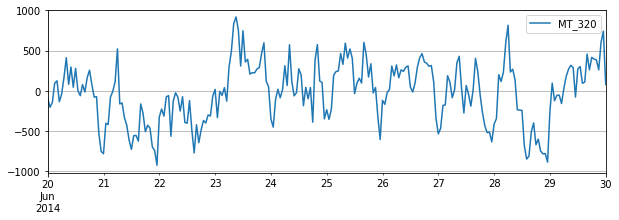

In [18]:
#残差曲线
p = predict_result.to_dataframe()
r = test_data.to_dataframe()
r = r[['MT_320']]
ts = TSDataset.load_from_dataframe((r - p).dropna(), target_cols="MT_320")
ts.plot()

上述结果表明，我们的优化策略是有效果的，通过优化模型参数和输入数据长度能够进一步提高模型泛化性，预测误差降低了8.6%（139654----->127653）

同时对比两次的预测残差曲线，优化之后的残差更接近于0均值的分布，证明在趋势性的学习上效果更好

我们在这里继续观察优化之后的预测误差的自相关性曲线，观察是否有显著的周期性数据残留在预测误差中

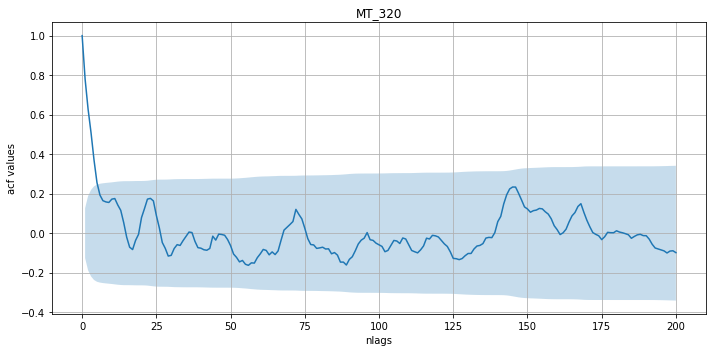

In [19]:
#自相关性
p = predict_result.to_dataframe()
r = test_data.to_dataframe()
r = r[['MT_320']]
ts = TSDataset.load_from_dataframe((r - p).dropna(), target_cols="MT_320")
acf = Acf(nlags=200)
ac = acf(ts)
plot = acf.plot()

从预测误差的自相关性角度观察，已经没有显著的周期性数据（蓝色区域之外没有顶点）

### 结论

数据分析与预测分析是一项非常重要的工作，合理的分析策略可以帮助快速定位关键问题，通过上述分析与优化的方法策略，我们进一步提升了模型预测效果，提升了模型对于趋势性与周期性的表达能力